#### Notes

Testing the beam smearing correction

- Take deconvolved image and do astronaut example on it to see how good it is at recovering image
- Use 0th moment
- Plot maps next to each other
- Check header from BMAJ, BMIN & the units

In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

import emcee
from emcee import EnsembleSampler, moves

In [2]:
num_bins = 31
# min and max bounds for each bin
vmin, vmax = 0, 200

# min and max inc, pos angle in RADIANS
inc_min, inc_max = np.radians(45), np.radians(75)
pos_angle_min, pos_angle_max = np.radians(0), np.radians(360)

name = "NGC2366"
distance = 3400. # [kpc]

home_directory = "/Users/stephencoffey/Downloads/little-things/BBarolo_runs/2D_output"
observed_2d_vel_field_fits_file = f"{home_directory}/{name}/{name}map_1st.fits"
observed_2d_intensity_field_fits_file = "/Users/stephencoffey/Downloads/little-things/BBarolo_runs/3D_output/NGC2366_ftype1/maps/NGC2366_0mom.fits"

# to use the dispersion as a source of errors, provide this file name
# observed_2d_dispersion_fits_file = f"{home_directory}/NGC2366_2mom.fits"
deg_per_pixel=4.17e-4

ring_param_file = f"{home_directory}/{name}/{name}_2dtrm.txt"
v_systemic = 100 #changed to 100 to equal exactly what we used in mathematica

In [3]:
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 65
mcmc_niter = 2000
mcmc_ndim = num_bins + 2  # Do not change this if fitting one ring at a time
mcmc_nthreads = 40
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash<br>
# Increase this; 2 is a very low value just for testing

batch_size = 50

# option to save outputs in a particular directory
save_dir = "/Users/stephencoffey/Downloads/little-things/mcmc_pickles/bb_comparison/31bins_5/"

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic,
    observed_2d_intensity_field_fits_file=observed_2d_intensity_field_fits_file
)

In [5]:
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

ring_param_bounds = [(vmin, vmax)] * num_bins + [(inc_min, inc_max), (pos_angle_min, pos_angle_max)]

In [6]:
fit_structural_params = {"inc": -2, "pos_angle": -1}

In [7]:
vels, pos_angles, incs = np.loadtxt(ring_param_file, usecols=(3, 5, 6)).T
radsep = ring_model.radii_kpc[-1] - ring_model.radii_kpc[-2]

bin_edges = [0 + i*radsep for i in range(len(ring_model.radii_kpc)+1)]
bin_edges = np.append(bin_edges, np.linspace(bin_edges[-1], 2 * bin_edges[-1], 4)[-3:])
bin_edges = np.append(bin_edges, 10000)
v_rot = np.append(vels, [vels[-1] for i in range(4)])
outer_bin_centers = [np.mean([bin_edges[i], bin_edges[i+1]]) for i in range(27,31)]

In [8]:
v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None
#v_err_2d = galaxy.observed_2d_dispersion

In [9]:
import warnings
warnings.simplefilter('ignore')
from fit2d._velocity_field_generator import create_2d_velocity_field

inc = np.radians(incs[0])  # grabbing one point in ringlog, since in BB it's const
pos_angle = np.radians(pos_angles[0]) # grabbing one point in ringlog, since in BB it's const

# if inc and/or pos_angle are not being fit in the MCMC, they will be fixed to constant values inc_fake, pos_angle_fake
ring_model.update_structural_parameters(inc=inc, pos_angle=pos_angle)

In [10]:
# creating the starting position bounds
bounds = []
for i in range(len(v_rot)):
    bounds.append((v_rot[i] - 1, v_rot[i] + 1))
bounds.extend([(inc - 0.1, inc + 0.1), (pos_angle - 0.1, pos_angle + 0.1)]) # only use if fitting inc and pa

In [11]:
from fit2d.mcmc._likelihood import chisq_2d, lnlike

bin_min, bin_max = bin_edges[0], bin_edges[-1]

# 1st moment map
galaxy.observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data
mask = np.nan_to_num(galaxy.observed_2d_vel_field/galaxy.observed_2d_vel_field, nan=0.)
dimensions = galaxy.observed_2d_vel_field.shape

# 0th moment map
observed_2d_intensity = fits.open(observed_2d_intensity_field_fits_file)[0].data


piecewise_model = PiecewiseModel(num_bins=num_bins)
piecewise_model.set_bounds(array_bounds=ring_param_bounds)
#piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
piecewise_model.bin_edges = bin_edges
radii_to_interpolate = np.append(ring_model.radii_kpc, outer_bin_centers) # manually gave bin centers to be the BB values + 4 outer bin centers
#print("bin centers:", radii_to_interpolate)
#radii_to_interpolate = np.array([r for r in bin_edges if bin_min<=r<=bin_max])
prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube
# instead of using piecewise_model.bounds, we've manually input bounds for the starting positions so the walkers start out much closer to the value we're looking for
start_positions = piecewise_start_points(mcmc_nwalkers, bounds = bounds, random_seed=random_seed)
fit_inputs = {
    "piecewise_model": piecewise_model,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "prior_transform": prior_transform
}


rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}

In [12]:
from fit2d.analysis.emcee import get_sampler_statistics

def loadpkl(num_bins, niter, path):
    d = {}
    with open(f'{path}/sampler_{name}_{niter}iter.pkl', 'rb') as f:
        d[f'saved_sampler_{name}'] = joblib.load(f)
    return d

d = loadpkl(31, 7900, "/Users/stephencoffey/Downloads/little-things/mcmc_pickles/31bins_struct_params")

for sampler in d.values():
        stats = list(get_sampler_statistics(sampler, min_iter = 3000, max_iter = 7900).values())
        model_avg = []
        for i in range(len(stats)):
            mean= list(stats[i].values())[0]
            model_avg.append(mean)
        last_model = np.mean(sampler.chain[:,-1,], axis = 0)

In [13]:
ringlog_vals = np.append(v_rot, [inc, pos_angle])

# Using start position to make model field
#r_m, v_m = piecewise_model.generate_1d_rotation_curve(start_positions[0], **rotation_curve_func_kwargs)

# Using exact values from ringlog
#r_m, v_m = piecewise_model.generate_1d_rotation_curve(ringlog_vals, **rotation_curve_func_kwargs)

# Using avg of chain (w/o burn in)
#r_m, v_m = piecewise_model.generate_1d_rotation_curve(model_avg, **rotation_curve_func_kwargs)

# Using last point in chain
r_m, v_m = piecewise_model.generate_1d_rotation_curve(last_model, **rotation_curve_func_kwargs)

model_field = create_2d_velocity_field(
        radii=r_m,
        v_rot=v_m,
        i=inc,
        pa=pos_angle,
        v_sys=galaxy.v_systemic,
        x_dim=galaxy.image_xdim,
        y_dim=galaxy.image_ydim,
        x_center=galaxy.image_xdim/2,
        y_center = galaxy.image_ydim/2,
        kpc_per_pixel=galaxy.kpc_per_pixel,
        r_min_kpc=np.min(r_m),
        r_max_kpc=np.max(r_m),
    )

mask = galaxy.observed_2d_vel_field/galaxy.observed_2d_vel_field

model_field *= mask

In [14]:
"""from astropy.convolution import Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=50, y_stddev=50)
plt.imshow(kernel)
plt.colorbar()"""

'from astropy.convolution import Gaussian2DKernel\nkernel = Gaussian2DKernel(x_stddev=50, y_stddev=50)\nplt.imshow(kernel)\nplt.colorbar()'

## Convolution step

In [15]:
from skimage import color, data, restoration
from scipy.signal import convolve2d as conv2d
from scipy.signal import fftconvolve as fftconv
from astropy.convolution import convolve_fft

bmaj = fits.open(observed_2d_intensity_field_fits_file)[0].header["BMAJ"]/deg_per_pixel
print("BMAJ:", bmaj)

BMAJ: 8.694724262350121


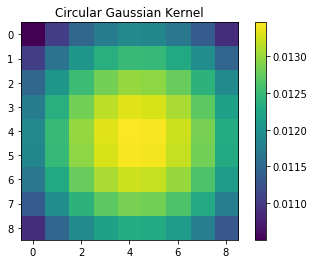

In [16]:
# circular Gaussian kernel of width BMAJ
x, y = np.meshgrid(np.arange(0,bmaj), np.arange(0,bmaj))
B = 2*np.pi*bmaj**2*np.exp(-1/(2*(bmaj**2)) * ((x-bmaj/2)**2 + (y-bmaj/2)**2))
# normalizing the beam
B /= np.sum(B)
np.sum(B) # should equal 1

plt.imshow(B)
plt.colorbar()
plt.title("Circular Gaussian Kernel")
plt.show()

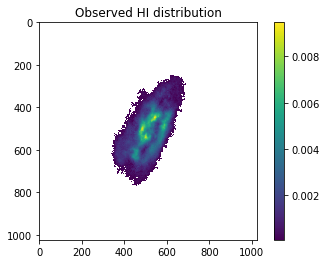

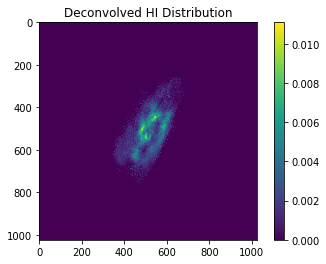

In [17]:
# obs HI distribution
plt.imshow(observed_2d_intensity)
plt.colorbar()
plt.title("Observed HI distribution")
plt.show()

# true HI distribution
data = np.nan_to_num(observed_2d_intensity, nan = 1e-9) # obs 0th mom w/ filled nans
N = restoration.richardson_lucy(data, B)
plt.imshow(N)
plt.colorbar()
plt.title("Deconvolved HI Distribution")
plt.show()

In [18]:
m0 = conv2d(N, B, mode = 'same')

In [19]:
fm0 = fftconv(N,B, mode = 'same')

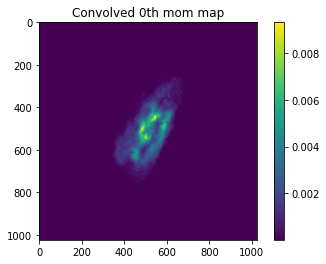

'plt.imshow(m0) \nplt.colorbar()\nplt.title("0th mom comparison")\nplt.show()'

In [20]:
plt.imshow(fm0)
plt.colorbar()
plt.title("Convolved 0th mom map")
plt.show()

"""plt.imshow(m0) 
plt.colorbar()
plt.title("0th mom comparison")
plt.show()"""

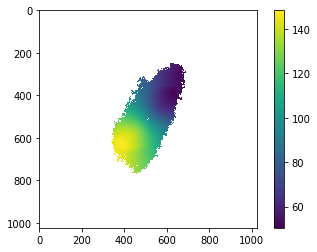

In [21]:
plt.imshow(model_field)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Intensity-weighted velocity field')

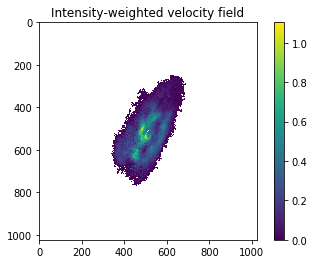

In [22]:
# True HI dist * model velocity field
plt.imshow(N*model_field)
plt.colorbar()
plt.title("Intensity-weighted velocity field")
# this will be convolved w/ Gaussian beam in next step

In [23]:
V = model_field*N

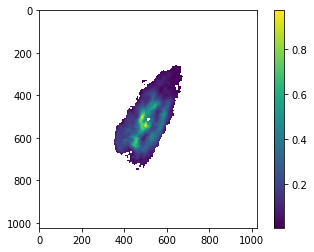

In [24]:
m1 = conv2d(V, B, mode = 'same')
plt.imshow(m1)
plt.colorbar()
plt.show()

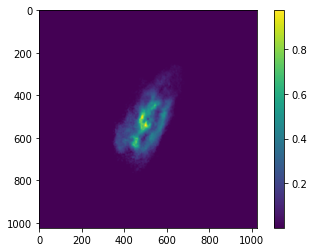

In [25]:
V = np.nan_to_num(V, nan = 1e-9)
m11 = conv2d(V, B, mode = 'same')
plt.imshow(m11)
plt.colorbar()
plt.show()

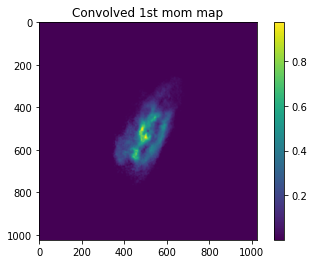

In [26]:
# convolving N*V(x,y) w/ cir Gaussian kernel
fm1 = fftconv(V, B, mode = 'same')
plt.imshow(fm1)
plt.colorbar()
plt.title("Convolved 1st mom map")
plt.show()

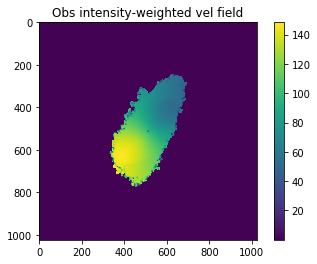

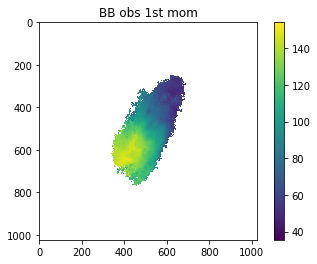

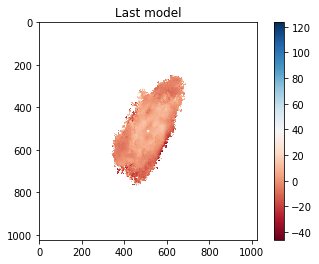

In [27]:
# Observed intensity-weighted mean velocity field w = m1/m0
w = fm1/fm0
plt.imshow(w)
plt.colorbar()
plt.title("Obs intensity-weighted vel field")
plt.show()

# Observed vel field map from BB
plt.imshow(galaxy.observed_2d_vel_field)
plt.colorbar()
plt.title("BB obs 1st mom")
plt.show()

# Comparison
diff = galaxy.observed_2d_vel_field - w
plt.imshow(diff, cmap = 'RdBu')
plt.colorbar()
plt.title("Last model")
#plt.savefig("last_model.png")
plt.show()

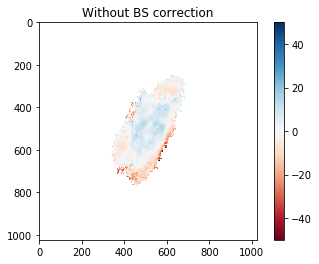

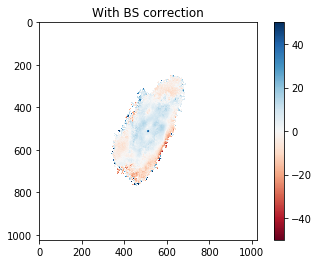

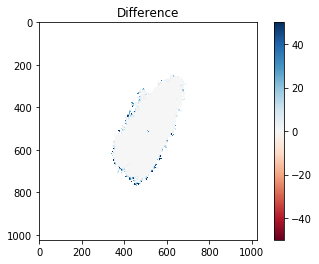

In [36]:
plt.imshow(galaxy.observed_2d_vel_field - model_field, vmin = -50, vmax = 50, cmap = 'RdBu')
plt.colorbar()
plt.title("Without BS correction")
plt.savefig("no_bs_correction.png")
plt.show()

plt.imshow(diff, vmin = -50, vmax = 50, cmap = 'RdBu')
plt.colorbar()
plt.title("With BS correction")
plt.savefig("bs_correction.png")
plt.show()

plt.imshow(model_field - w, vmin = -50, vmax = 50, cmap = 'RdBu')
plt.colorbar()
plt.title("Difference")
plt.savefig("diff_of_w_and_no_bs.png")
plt.show()